In [287]:
import datetime

import pandas as pd
import spacy
import re
import string
import numpy as np
import sys

import seaborn as sns
from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

from spacy.tokens import Token
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.corpus import stopwords

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score

import gensim
from gensim import corpora, models
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec
import multiprocessing

from sklearn.model_selection import cross_val_score , GridSearchCV,train_test_split

from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

import enchant
pd.set_option('display.max_rows', 500)

In [6]:
dict_check = enchant.Dict("en_US")

#### Importing the file ####
Path="src/"
Filename='projects_Preprocessed.csv'
df=pd.read_csv(Path+Filename)

Cat_File="category_hier.csv"
Cat_data=pd.read_csv(Path+Cat_File)

varcluster_file="variable_clusters.csv"
varcluster=pd.read_csv(Path+varcluster_file)

varcluster_info=pd.DataFrame(
{'cluster_id'  :[ '0' , '1' , '2' , '3' , '4' , '5' , '6' , '7' , '8' , '9' , '10', '11', '12', '13', '14', '15']
,'cluster_name':[ 'General' ,'Life Sciences' ,'Humanities and Social Sciences' ,'Engineering Sciences' ,'Natural Sciences' ,'Medicine' ,'Foundation & Acquisition' ,'Chemistry & Mechanical & Electrical' ,'Life Sciences' ,'Physics & Mathematical & Geometry & Analytical & Computer' ,'Eco System & Chemistry' ,'History & Cultural' ,'Climate & Earth' ,'Human & Experiment' ,'Biology & Genetics' ,'Text & Publish' ]
,'category'   :['General', 'Life Sciences', 'Humanities and Social Sciences', 'Engineering Sciences', 'Natural Sciences', 'Life Sciences', 'Uncategorized',  'Uncategorized',  'Life Sciences',  'Uncategorized' , 'Natural Sciences',  'Humanities and Social Sciences',  'Natural Sciences', 'Uncategorized', 'Uncategorized',  'General']
})

df=df[df['Translates']!="The goal of the Heisenberg Program is to enable outstanding scientists who fulfill all the requirements for a long-term professorship to prepare for a scientific leadership role and to work on further research topics during this time. In pursuing this goal, it is not always necessary to choose and implement project-based procedures. For this reason, in the submission of applications and later in the preparation of final reports - unlike other support instruments - no 'summary' of project descriptions and project results is required. Thus, such information is not provided in GEPRIS."]

## Filtering the null abstracts & short description
df=df[(pd.isnull(df.PreProcessedDescription)==False) & (df.PreProcessedDescription.str.strip()!='abstract available')& (df.PreProcessedDescription.str.len()>100) & (pd.isnull(df["SubjectArea"])==False)]

In [7]:
Cat_data.Category=Cat_data.Category.str.strip()

In [8]:
df=df.merge(Cat_data[["File_Categories","Category"]], how="left", left_on="SubjectArea", right_on="File_Categories")

In [9]:
def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

def create_tagged_document_based_on_tags(list_of_list_of_words, tags):
    for i in range(len(list_of_list_of_words)):
        yield gensim.models.doc2vec.TaggedDocument(list_of_list_of_words[i], [tags[i]])

def vec_for_learning(model, tagged_docs):
    sents = tagged_docs#.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [10]:
DescDict=[[x for x in str(i).split()] for i in df.PreProcessedDescription]
tagged_value_tags = list(create_tagged_document_based_on_tags(DescDict, df.Category.tolist()))
tagged_value = list(create_tagged_document(DescDict))

In [11]:
print(str(datetime.datetime.now()),'Started')

# Init the Doc2Vec model
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=5, epochs=40, alpha = 0.02, dm=1, workers=multiprocessing.cpu_count())

# Build the Volabulary
model.build_vocab(tagged_value)

model.train(tagged_value, total_examples=len(tagged_value), epochs=40)

print(str(datetime.datetime.now()),'Completed')

2020-01-17 12:03:19.568899 Started
2020-01-17 12:17:24.351585 Completed


In [13]:
modelchecked=model
target_word='environment'
print('target_word: %r model: %s similar words:' % (target_word, modelchecked))
for i, (word, sim) in enumerate(modelchecked.wv.most_similar(target_word, topn=20), 1):
    print('    %d. %.2f %r' % (i, sim, word))

target_word: 'environment' model: Doc2Vec(dm/m,d50,n5,w5,mc5,s0.001,t4) similar words:
    1. 0.69 'situation'
    2. 0.65 'habitat'
    3. 0.65 'system'
    4. 0.64 'kind'
    5. 0.62 'condition'
    6. 0.62 'scenario'
    7. 0.61 'climatically'
    8. 0.61 'community'
    9. 0.61 'constantly'
    10. 0.61 'contexts'
    11. 0.60 'setting'
    12. 0.60 'way'
    13. 0.58 'network'
    14. 0.57 'resource'
    15. 0.57 'obviously'
    16. 0.57 'area'
    17. 0.57 'medium'
    18. 0.56 'continuously'
    19. 0.56 'landscape'
    20. 0.56 'interface'


In [14]:
ps=10
pcamodel = PCA(n_components=ps)
pca=pcamodel.fit_transform(model.docvecs.vectors_docs)
print('PCA components :',ps,'Variance coveragence' ,np.max(pcamodel.explained_variance_ratio_.cumsum())*100)

PCA components : 10 Variance coveragence 38.27081322669983


In [15]:
#merged_data=df.merge(Cat_data[["File_Categories","Category"]], how="left", left_on="SubjectArea", right_on="File_Categories")
#merged_data.Category=merged_data.Category.str.strip()

dummies=pd.get_dummies(df['Category'])
merged_data=pd.concat([df,dummies], axis=1,ignore_index=False)

merged_data=pd.concat([merged_data,pd.DataFrame(pca)], axis=1,ignore_index=False)

merged_data=merged_data[pd.isnull(merged_data["Category"])==False]
merged_data['DBScanCluster']=0

In [17]:
#200 - 1.9

FeatureCols=list(range(ps))

for cat in merged_data.Category.unique():
    print(str(datetime.datetime.now()),'Started')
    CategoricalDS= merged_data[FeatureCols][merged_data.Category==cat]
    clusterer  =IsolationForest(n_estimators=100, max_samples='auto',behaviour="new", contamination='auto', max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
    preds = clusterer.fit_predict(CategoricalDS)
    
    merged_data['DBScanCluster'][merged_data.Category==cat]=preds
    print('******'+cat+'******')
    print(pd.Series(preds).value_counts())
    score = silhouette_score(CategoricalDS, preds, metric='euclidean')
    print('silhouette score:',score)
    print(str(datetime.datetime.now()),'Completed')
    print('')
    

2020-01-17 13:36:55.266425 Started


/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


******Natural Sciences******
 1    12500
-1     1224
dtype: int64
silhouette score: 0.25810522
2020-01-17 13:37:10.071965 Completed

2020-01-17 13:37:10.072176 Started


/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


******Humanities and Social Sciences******
 1    8934
-1    1050
dtype: int64
silhouette score: 0.27578232
2020-01-17 13:37:14.497331 Completed

2020-01-17 13:37:14.497463 Started


/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


******Engineering Sciences******
 1    8384
-1     992
dtype: int64
silhouette score: 0.24181983
2020-01-17 13:37:18.293793 Completed

2020-01-17 13:37:18.293890 Started


/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


******Life Sciences******
 1    15917
-1     2032
dtype: int64
silhouette score: 0.2592891
2020-01-17 13:37:28.656504 Completed



In [18]:
#NewMergedDS.DBScanCluster.value_counts()
merged_data['DBScanCluster'].value_counts()

 1    45735
-1     5298
Name: DBScanCluster, dtype: int64

In [19]:
merged_data=merged_data.reset_index()[merged_data.columns[0:]]

In [20]:
merged_data['CategoryConv']=''
merged_data['CategoryConv'][merged_data['Category']=='Engineering Sciences']=0
merged_data['CategoryConv'][merged_data['Category']=='Humanities and Social Sciences']=1
merged_data['CategoryConv'][merged_data['Category']=='Natural Sciences']=2
merged_data['CategoryConv'][merged_data['Category']=='Life Sciences']=3

merged_data['CategoryConv']=merged_data['CategoryConv'].astype('int')

/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/U

In [21]:
merged_data.columns[16:len(merged_data.columns)-2]

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='object')

In [23]:
Features=merged_data.columns[16:len(merged_data.columns)-2] #list(range(500))

merged_data[Features]=MinMaxScaler().fit_transform(merged_data[Features])

OP_Feature='CategoryConv'

X_Training_DS=merged_data[Features][merged_data.DBScanCluster==1]
y_Training_DS=merged_data[OP_Feature][merged_data.DBScanCluster==1]

X_Test_DS=merged_data[Features][merged_data.DBScanCluster!=1]
y_Test_DS=merged_data[OP_Feature][merged_data.DBScanCluster!=1]

X_train, X_test, y_train, y_test = train_test_split(X_Training_DS,y_Training_DS,  test_size=0.2, random_state=0)

Accuracy Score : 35.48704493276484


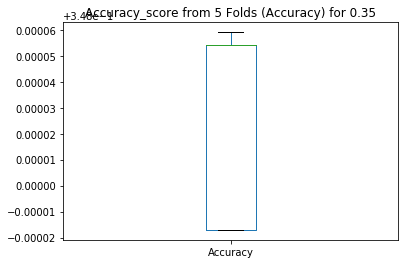

In [24]:
modelNB = MultinomialNB(alpha=1)
modelNB.fit(X_train, y_train)

nfolds=5
scores=cross_val_score(modelNB, X_Training_DS,y_Training_DS, cv=nfolds, scoring="accuracy")
pd.Series(scores).plot(kind="box", label="Accuracy");
plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

y_pred = modelNB.predict(X_test)
print('Accuracy Score : '+str(accuracy_score(y_test,y_pred )*100))

neighbors: 25 Accuracy Score : 0.8821471520717175


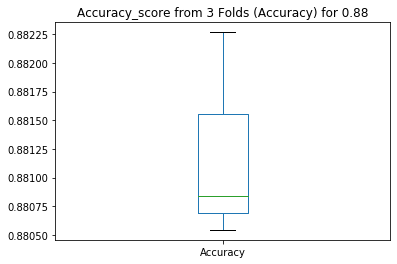

In [25]:
for k in [25]:
    modelKBC = KNeighborsClassifier(n_neighbors=k)
    modelKBC.fit(X_train, y_train)

    y_pred = modelKBC.predict(X_test)
    print('neighbors:',k,'Accuracy Score : '+str(accuracy_score(y_test,y_pred )))

    nfolds=3
    scores=cross_val_score(modelKBC, X_train,y_train, cv=nfolds, scoring="accuracy")
    pd.Series(scores).plot(kind="box", label="Accuracy");
    plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

2020-01-17 13:59:16.184298 Started
2020-01-17 13:59:16.964902 Fit Completed
Accuracy Score : 84.58510987208922
2020-01-17 13:59:18.174792 Completed


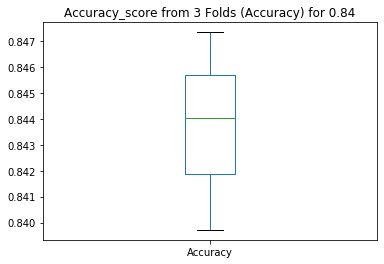

In [26]:
print(str(datetime.datetime.now()),'Started')

modelSVC = svm.LinearSVC(C=0.01)
modelSVC.fit(X_train, y_train)

print(str(datetime.datetime.now()),'Fit Completed')
nfolds=3
scores=cross_val_score(modelSVC, X_train, y_train, cv=nfolds, scoring="accuracy")
pd.Series(scores).plot(kind="box", label="Accuracy");
plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

y_pred = modelSVC.predict(X_test)
print('Accuracy Score : '+str(accuracy_score(y_test,y_pred )*100))

print(str(datetime.datetime.now()),'Completed')

In [27]:
def name_max_value(DF):
    colname='Category_1_Values'
    if (DF['Engineering Sciences']==DF[colname]):
        return 'Engineering Sciences'
    elif (DF['Humanities and Social Sciences']==DF[colname]):
        return 'Humanities and Social Sciences'
    elif (DF['Natural Sciences']==DF[colname]):
        return 'Natural Sciences'
    elif (DF['Life Sciences']==DF[colname]):
        return 'Life Sciences'
    else:
        return ''
    
def name_sec_max_value(DF):
    colname='Category_2_Values'
    if(DF[colname]==0):
        return ''
    elif ((DF['Engineering Sciences']==DF[colname]) & (DF['Category_1']!='Engineering Sciences')):
        return 'Engineering Sciences'
    elif ((DF['Humanities and Social Sciences']==DF[colname]) & (DF['Category_1']!='Humanities and Social Sciences')):
        return 'Humanities and Social Sciences'
    elif ((DF['Natural Sciences']==DF[colname]) & (DF['Category_1']!='Natural Sciences')):
        return 'Natural Sciences'
    elif ((DF['Life Sciences']==DF[colname]) & (DF['Category_1']!='Life Sciences')):
        return 'Life Sciences'
    else:
        return ''
    
def name_3rd_max_value(DF):
    colname='Category_3_Values'
    if(DF[colname]==0):
        return ''
    elif ((DF['Engineering Sciences']==DF[colname]) & (DF['Category_2']!='Engineering Sciences')):
        return 'Engineering Sciences'
    elif ((DF['Humanities and Social Sciences']==DF[colname]) & (DF['Category_2']!='Humanities and Social Sciences')):
        return 'Humanities and Social Sciences'
    elif ((DF['Natural Sciences']==DF[colname]) & (DF['Category_2']!='Natural Sciences')):
        return 'Natural Sciences'
    elif ((DF['Life Sciences']==DF[colname]) & (DF['Category_2']!='Life Sciences')):
        return 'Life Sciences'
    else:
        return ''

In [28]:
#matching_category()
cols=['Engineering Sciences','Humanities and Social Sciences','Natural Sciences','Life Sciences']
PredictedValues=pd.DataFrame(modelKBC.predict_proba(merged_data[Features]), columns=cols)
PredictedValues['Category_1_Values']=PredictedValues[cols].apply(np.max,axis=1)
PredictedValues['Category_2_Values']=PredictedValues[cols].apply(np.sort,axis=1).apply(lambda x:x[2])
PredictedValues['Category_3_Values']=PredictedValues[cols].apply(np.sort,axis=1).apply(lambda x:x[1])

PredictedValues['Category_1']=PredictedValues.apply(name_max_value,axis=1)
PredictedValues['Category_2']=PredictedValues.apply(name_sec_max_value,axis=1)
PredictedValues['Category_3']=PredictedValues.apply(name_3rd_max_value,axis=1)

PredictedValues['Category_12_Variance']=PredictedValues.apply(lambda x :x['Category_1_Values']-x['Category_2_Values'], axis=1)
PredictedValues['Category_23_Variance']=PredictedValues.apply(lambda x :x['Category_2_Values']-x['Category_3_Values'], axis=1)

In [29]:
PredictedValues.head(16694).tail(5)

,Engineering Sciences,Humanities and Social Sciences,Natural Sciences,Life Sciences,Category_1_Values,Category_2_Values,Category_3_Values,Category_1,Category_2,Category_3,Category_12_Variance,Category_23_Variance
16689,0.00,0.00,0.04,0.96,0.96,0.04,0.00,Life Sciences,Natural Sciences,,0.92,0.04
16690,0.00,0.00,0.80,0.20,0.80,0.20,0.00,Natural Sciences,Life Sciences,,0.60,0.20
16691,0.04,0.08,0.52,0.36,0.52,0.36,0.08,Natural Sciences,Life Sciences,Humanities and Social Sciences,0.16,0.28
16692,0.08,0.00,0.88,0.04,0.88,0.08,0.04,Natural Sciences,Engineering Sciences,Life Sciences,0.80,0.04
16693,0.00,0.00,1.00,0.00,1.00,0.00,0.00,Natural Sciences,,,1.00,0.00


In [30]:
NewMergedDSAligned=pd.concat([merged_data[merged_data.columns.tolist()[:12]+['DBScanCluster']],PredictedValues[PredictedValues.columns[4:]]], axis=1, ignore_index=False)

In [31]:
#(NewMergedDSAligned.DBScanCluster!=0) &

NewMergedDSAligned['DBScanCluster'][ (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].value_counts()

 1    5112
-1    1395
Name: DBScanCluster, dtype: int64

In [59]:
NewMergedDSAligned['Category'][(NewMergedDSAligned.DBScanCluster!=1) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].value_counts()

Life Sciences                     519
Natural Sciences                  424
Engineering Sciences              265
Humanities and Social Sciences    187
Name: Category, dtype: int64

In [61]:
cats='Engineering Sciences'
lim=200
NewMergedDSAligned[['Translates','Category']+NewMergedDSAligned.columns[13:].tolist()][(NewMergedDSAligned['Category_1']!=cats) &  (NewMergedDSAligned['Category']==cats) & (NewMergedDSAligned.DBScanCluster!=1) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_1_Values', ascending=False).head(lim).tail(5)

,Translates,Category,Category_1_Values,Category_2_Values,Category_3_Values,Category_1,Category_2,Category_3,Category_12_Variance,Category_23_Variance
39025,The spatial categorisation of traffic accident...,Engineering Sciences,0.56,0.20,0.16,Humanities and Social Sciences,Life Sciences,Natural Sciences,0.36,0.04
46702,Temporal synchrony of firing neuronal ensemble...,Engineering Sciences,0.56,0.44,0.00,Life Sciences,Humanities and Social Sciences,,0.12,0.44
46098,The proposed project aims at developing a deta...,Engineering Sciences,0.56,0.44,0.00,Natural Sciences,Engineering Sciences,,0.12,0.44
5879,Building on previous development and preparato...,Engineering Sciences,0.56,0.40,0.04,Life Sciences,Humanities and Social Sciences,Engineering Sciences,0.16,0.36
16864,"Lipopolysaccharides (LPS, endotoxins) are comp...",Engineering Sciences,0.56,0.40,0.04,Life Sciences,Engineering Sciences,Natural Sciences,0.16,0.36


In [62]:
#cats='Humanities and Social Sciences'
NewMergedDSAligned[['Translates','Category_1_Values']][(NewMergedDSAligned['Category_1']!=cats) &  (NewMergedDSAligned['Category']==cats) & (NewMergedDSAligned.DBScanCluster!=1) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_1_Values', ascending=False).Translates.head(lim).tail(5).tolist()#.tail().

["The spatial categorisation of traffic accidents is typically made on the basis of places of accident. This approach, however, leaves only limited room for conclusions about population-based risks, because the place of accident does not necessarily match a victim's place of residence. This project employs a residence-based approach to geographically analyse population-based accident risks. Combined place-of-residence and place-of-accident-based analyses are undertaken as well.The analyses are based on accident casualty counts provided by the Lower Saxony Ministry of the Interior covering the period 2006-2013. They include the number of casualties, categorised by severity of accident, age, sex and transport mode. The data include postal codes of the casualties' place of residence and place of accident. These data will be matched with sociodemographic, economic, exposure, transport-related and urban form attributes.Doing so, associations between these context attributes and population-b

In [45]:
#NewMergedDSAligned.to_csv(Path+'WEPCAISOForestFindingsTFIDF.csv', index=False)

In [191]:
#&(NewMergedDSAligned['Category']==cats) &(NewMergedDSAligned['Category_1']==check_cat)

input_data=NewMergedDSAligned[(NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1']) & (NewMergedDSAligned.DBScanCluster!=0) ]

input_data.loc[:,'CategoryCollc']=input_data[['Category','Category_1','Category_2','Category_3']].apply(lambda x:x[0]+','+x[1]+','+x[2]+','+x[3], axis=1)
input_data.loc[:,'CategoryCollc']=input_data['CategoryCollc'].str.strip(",")

/Users/balaji/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/balaji/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [35]:
varcluster_info.cluster_id=varcluster_info.cluster_id.astype('int32')
varcluster=varcluster.merge(varcluster_info, how='left',left_on='Cluster', right_on='cluster_id')

Engineering Sciences - ['Humanities and Social Sciences'] : Number of Documents - 17
             0       Variable                        category
40    3.105701        project                         General
323   2.892729       planning            Engineering Sciences
178   2.845909     experience  Humanities and Social Sciences
267   2.673939   architecture            Engineering Sciences
228   2.398566          urban  Humanities and Social Sciences
284   2.360751         design            Engineering Sciences
315   2.181310            new            Engineering Sciences
214   2.138898       research  Humanities and Social Sciences
660   1.929090       building                   Life Sciences
161   1.893717           city  Humanities and Social Sciences
845   1.767592          study                Natural Sciences
66    1.602263           work                         General
206   1.595788      political  Humanities and Social Sciences
1003  1.567808         jewish                  

             0          Variable                        category
221   0.974479            social  Humanities and Social Sciences
798   0.772596             model                Natural Sciences
1003  0.560234           housing                             NaN
1003  0.515064  psycholinguistic                             NaN
845   0.483702             study                Natural Sciences
623   0.466862             local                   Life Sciences
1     0.465908               aim                         General
1003  0.465623          schultze                             NaN
1003  0.465623          naumburg                             NaN
267   0.465623      architecture            Engineering Sciences
744   0.451403          approach                Natural Sciences
844   0.441500           network                Natural Sciences
214   0.380023          research  Humanities and Social Sciences
330   0.373489           process            Engineering Sciences
847   0.372498           

             0    Variable              category
1003  0.664705         leg                   NaN
844   0.608880     network      Natural Sciences
1003  0.472528  oscillator                   NaN
108   0.420117    neuronal         Life Sciences
1003  0.398823         cpg                   NaN
368   0.388588    coupling      Natural Sciences
103   0.377940   mechanism         Life Sciences
617   0.357058        know         Life Sciences
122   0.325529      signal         Life Sciences
770   0.325529   different      Natural Sciences
142   0.293999  understand         Life Sciences
402   0.265882      system      Natural Sciences
107   0.262470      neuron         Life Sciences
975   0.262470        type         Uncategorized
1003  0.221568       inter                   NaN
1003  0.221568      insect                   NaN
798   0.177255       model      Natural Sciences
1003  0.177255       stick                   NaN
303   0.177255       joint  Engineering Sciences
790   0.132941   inf

             0     Variable                        category
40   12.551875      project                         General
798  12.225261        model                Natural Sciences
330  10.613191      process            Engineering Sciences
402   9.066181       system                Natural Sciences
707   9.010556      problem                   Uncategorized
698   8.607694       method                   Uncategorized
673   8.601956    algorithm                   Uncategorized
214   8.410108     research  Humanities and Social Sciences
62    7.821368         time                         General
517   7.544173         high                   Uncategorized
285   7.507725      develop            Engineering Sciences
307   7.067951     material            Engineering Sciences
415   6.814300  measurement                Natural Sciences
50    6.655478       result                         General
743   6.160652     analysis                Natural Sciences
318   6.027998        order            E

Humanities and Social Sciences - ['Engineering Sciences', 'Humanities and Social Sciences', 'Engineering Sciences'] : Number of Documents - 1
             0        Variable                        category
217   0.538462         science  Humanities and Social Sciences
214   0.461538        research  Humanities and Social Sciences
347   0.307692      technology            Engineering Sciences
999   0.230769            year                         General
606   0.230769          theory                   Life Sciences
1003  0.230769             war                             NaN
315   0.153846             new            Engineering Sciences
584   0.153846            area                   Life Sciences
1003  0.153846        emphasis                             NaN
691   0.153846            flow                   Uncategorized
235   0.153846       knowledge  Humanities and Social Sciences
941   0.153846          nature                   Uncategorized
666   0.153846         physics         

             0       Variable                        category
40    1.684891        project                         General
734   1.535877          datum                   Uncategorized
1     1.469544            aim                         General
214   1.101461       research  Humanities and Social Sciences
350   1.055357            use            Engineering Sciences
517   0.985455           high                   Uncategorized
1003  0.956349            ecs                             NaN
1003  0.948797     greifswald                             NaN
504   0.916386         defect                   Uncategorized
743   0.834349       analysis                Natural Sciences
437   0.819098          heart                   Life Sciences
759   0.811068      cognitive                Natural Sciences
402   0.772380         system                Natural Sciences
951   0.731170        genetic                   Uncategorized
698   0.717024         method                   Uncategorized
170   0.

             0     Variable                        category
606   5.661895       theory                   Life Sciences
1003  4.688836   settlement                             NaN
584   4.589357         area                   Life Sciences
741   4.555340          age                Natural Sciences
379   4.355745         find                Natural Sciences
845   4.300779        study                Natural Sciences
40    3.801205      project                         General
666   3.760866      physics                   Life Sciences
340   3.429034         site            Engineering Sciences
773   3.162609        early                Natural Sciences
210   3.056888     question  Humanities and Social Sciences
214   3.013197     research  Humanities and Social Sciences
62    2.945447         time                         General
1003  2.876888   excavation                             NaN
556   2.849222    structure                   Uncategorized
698   2.797575       method             

             0       Variable                        category
1003  1.211178   agricultural                             NaN
66    0.982809           work                         General
306   0.704506        machine            Engineering Sciences
402   0.654825         system                Natural Sciences
322   0.651479    performance            Engineering Sciences
1003  0.616106       acoustic                             NaN
1003  0.615862         driver                             NaN
330   0.612653        process            Engineering Sciences
348   0.585535           tool            Engineering Sciences
40    0.571263        project                         General
162   0.547650  communication  Humanities and Social Sciences
412   0.540697         device                Natural Sciences
285   0.499437        develop            Engineering Sciences
1003  0.468428            tmf                             NaN
1003  0.462261           loop                             NaN
284   0.

             0     Variable                        category
845  52.751333        study                Natural Sciences
450  36.872133      patient                   Life Sciences
40   33.676571      project                         General
989  30.481240       effect                         General
330  30.117882      process            Engineering Sciences
214  29.812840     research  Humanities and Social Sciences
991  27.580976  investigate                         General
425  26.443240        brain                   Life Sciences
433  26.088449     disorder                   Life Sciences
103  25.045592    mechanism                   Life Sciences
1    24.184005          aim                         General
50   24.063971       result                         General
221  23.998309       social  Humanities and Social Sciences
780  23.735598      examine                Natural Sciences
3    23.725502         base                         General
798  22.825626        model             

            0     Variable                        category
214  2.319476     research  Humanities and Social Sciences
798  1.974211        model                Natural Sciences
845  1.700120        study                Natural Sciences
713  1.504721   simulation                   Uncategorized
744  1.200329     approach                Natural Sciences
40   0.962709      project                         General
572  0.901748        phase                   Uncategorized
2    0.886760  application                         General
734  0.845369        datum                   Uncategorized
719  0.784369     variable                   Uncategorized
570  0.717119        water                   Uncategorized
546  0.685035     property                   Uncategorized
673  0.657002    algorithm                   Uncategorized
743  0.621753     analysis                Natural Sciences
755  0.618637       change                Natural Sciences
832  0.614673    transport                Natural Scienc

             0     Variable                        category
620  47.922765      protein                   Life Sciences
40   38.563378      project                         General
214  32.482910     research  Humanities and Social Sciences
556  31.136691    structure                   Uncategorized
845  30.310857        study                Natural Sciences
698  30.232383       method                   Uncategorized
402  28.670953       system                Natural Sciences
798  28.231372        model                Natural Sciences
517  26.962486         high                   Uncategorized
770  26.169822    different                Natural Sciences
330  25.993193      process            Engineering Sciences
1    24.132881          aim                         General
315  24.114339          new            Engineering Sciences
546  23.696800     property                   Uncategorized
570  22.973624        water                   Uncategorized
621  22.664630  interaction             

             0     Variable                        category
844   1.458803      network                Natural Sciences
40    1.355632      project                         General
734   1.297213        datum                   Uncategorized
330   1.215727      process            Engineering Sciences
209   0.943243       public  Humanities and Social Sciences
228   0.923520        urban  Humanities and Social Sciences
3     0.908915         base                         General
584   0.864620         area                   Life Sciences
402   0.862688       system                Natural Sciences
285   0.845040      develop            Engineering Sciences
2     0.810230  application                         General
698   0.686793       method                   Uncategorized
524   0.631994     learning                   Uncategorized
370   0.610180      dynamic                Natural Sciences
664   0.571304   particular                   Life Sciences
572   0.454806        phase             

             0      Variable                        category
1003  0.592870          firm                             NaN
1003  0.474296    innovation                             NaN
164   0.470860       company  Humanities and Social Sciences
195   0.392080        market  Humanities and Social Sciences
1003  0.392080     financial                             NaN
354   0.364773       product            Engineering Sciences
843   0.313907    individual                Natural Sciences
1003  0.313907    dependency                             NaN
729   0.313907      modeling                   Uncategorized
798   0.313907         model                Natural Sciences
1003  0.313907     contagion                             NaN
1003  0.313907       default                             NaN
457   0.307714          risk                   Life Sciences
1003  0.237148    constraint                             NaN
459   0.237148      strategy                   Life Sciences
1003  0.237148    invest

             0         Variable              category
40    2.953271          project               General
285   2.156162          develop  Engineering Sciences
572   1.655718            phase         Uncategorized
698   1.334194           method         Uncategorized
798   1.236173            model      Natural Sciences
744   1.036150         approach      Natural Sciences
844   0.966891          network      Natural Sciences
743   0.961842         analysis      Natural Sciences
734   0.908575            datum         Uncategorized
21    0.897878             goal               General
1003  0.882603          seizure                   NaN
845   0.685807            study      Natural Sciences
402   0.631639           system      Natural Sciences
85    0.624272             cell         Life Sciences
948   0.555264       expression         Uncategorized
1003  0.553800  synchronization                   NaN
621   0.529784      interaction         Life Sciences
62    0.521533             t

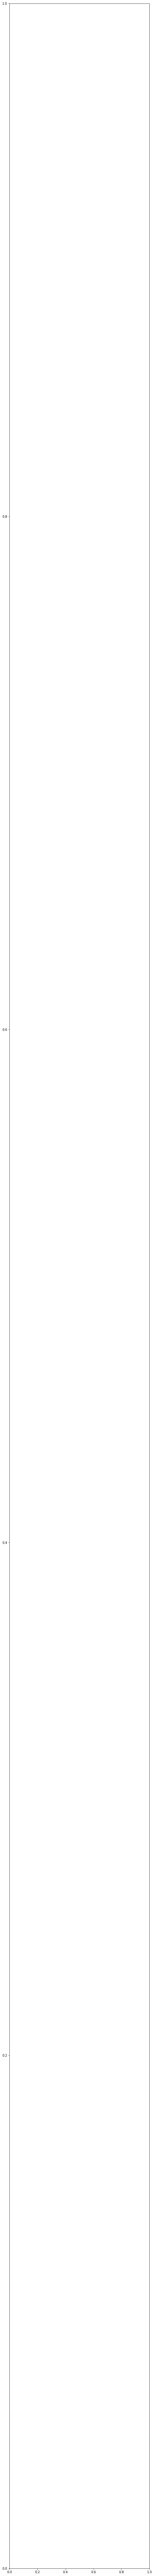

In [44]:
sizes=len(input_data.CategoryCollc.unique())
plt.subplots(figsize=(8,150)) 
j=1

for i,bucket in input_data.groupby(['CategoryCollc']):
    print(i.split(',')[0],'-',i.split(',')[1:],': Number of Documents -',len(bucket))
    
    vectorizer = TfidfVectorizer(max_features=20, ngram_range=(1, 1))
    review_vectors = vectorizer.fit_transform(bucket["PreProcessedDescription"])
    features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())

    #print(features_df.sum().sort_values(ascending=False),'\n')
    
    print(pd.DataFrame(features_df.sum().sort_values(ascending=False)).merge(varcluster, how='left', left_index=True, right_on='Variable')[[0,'Variable', 'category']])
    print('----------------------------------------------------------')
    #vectorizer.get_feature_names()
 
    #plt.subplot(1,sizes,j)
    #features_df.sum().sort_values(ascending=False).plot(kind='bar',color='green')
    #plt.title(i.split(',')[0]+' -'+','.join(i.split(',')[1:]))
    #plt.xticks(rotation=60)
    
    #j=j+1
    #plt.tight_layout()

In [71]:
#df.Topic_Keywords.unique().tolist()

#for i,w in df.groupby(['OCategory','NCategory']):
#    print(i)
#    print(w.Topic_Keywords.tolist())
#    print('\n')

In [67]:
NewMergedDSAligned2=pd.concat([merged_data,PredictedValues[PredictedValues.columns[4:]]], axis=1, ignore_index=False)
def CattoID(input_cat):
    if(input_cat=='Engineering Sciences'):
        return 0
    elif(input_cat=='Humanities and Social Sciences'):
        return 1
    elif(input_cat=='Natural Sciences'):
        return 2
    elif(input_cat=='Life Sciences'):
        return 3
    else :
        return -1

NewMergedDSAligned2.loc[:,'Category_1_ID']=NewMergedDSAligned2.Category_1.apply(CattoID)
NewMergedDSAligned2.loc[:,'Category_2_ID']=NewMergedDSAligned2.Category_2.apply(CattoID)
NewMergedDSAligned2.loc[:,'Category_3_ID']=NewMergedDSAligned2.Category_3.apply(CattoID)

In [281]:
cats=['Engineering Sciences','Humanities and Social Sciences', 'Life Sciences','Natural Sciences']
cats_dist=[]

## Finiding the overall similiarity

for c, w in NewMergedDSAligned2[(NewMergedDSAligned2['Category']!=NewMergedDSAligned2['Category_1']) & (NewMergedDSAligned2['DBScanCluster']!=1)].groupby('Category'):
    #print('')
    #print(c, len(w))
    #other_cat=list(filter(lambda x:x!=c, cats))
    cat_dist=[]
    for oc in cats:
        if oc==c:
            oc_sim=0
            
        else:
            oc_sum=sum(w[w['Category_1']==oc].Category_1_Values.tolist()+w[w['Category_2']==oc].Category_2_Values.tolist()+w[w['Category_3']==oc].Category_3_Values.tolist())
            oc_sim=oc_sum/len(w)
            
        cat_dist.append(oc_sim)
        #print(c,':',oc,'-', round(oc_sim,2))
        
        #oc_sum=w[w['Category_1']==oc].Category_1_Values.tolist()+w[w['Category_2']==oc].Category_2_Values.tolist()+w[w['Category_3']==oc].Category_3_Values.tolist()
        #oc_sim=sum(oc_sum)/len(oc_sum)
        #print(c,':',oc,'-', round(oc_sim,2))
    cats_dist.append(np.array(cat_dist))
cats_dist=np.array(cats_dist)

## Making symmetric matrix
sym_dist=np.zeros(cats_dist.shape)
for i in range(cats_dist.shape[0]):
    for j in range(cats_dist.shape[0]):
        sym_dist[i][j]=cats_dist[i][j]+ cats_dist[j][i]
        if(i==j):
            sym_dist[i][j]=1

# 1-x : convert similiarity to distance
sym_dist=1-pd.DataFrame(sym_dist, columns=cats, index=cats)

In [304]:
sym_dist#.unstack()

,Engineering Sciences,Humanities and Social Sciences,Life Sciences,Natural Sciences
Engineering Sciences,0.000000,0.473798,0.597470,0.385981
Humanities and Social Sciences,0.473798,0.000000,0.320156,0.692084
Life Sciences,0.597470,0.320156,0.000000,0.375252
Natural Sciences,0.385981,0.692084,0.375252,0.000000


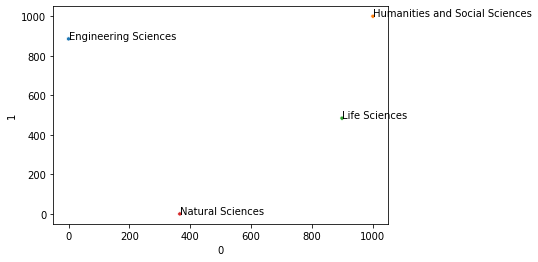

In [422]:
## Generating coordinates from distance

coords = TSNE(n_components=2,perplexity=1, random_state=3, metric='precomputed').fit_transform(sym_dist)
#coords = TSNE(n_components=2,perplexity=.2, random_state=3, metric='precomputed').fit_transform(sym_dist)
coords=MinMaxScaler([0,1000]).fit_transform(coords)
coords=pd.DataFrame(coords, index=cats).reset_index()
p1=sns.scatterplot(
    x=0, y=1,
    hue="index",
 #   palette=sns.color_palette("hls", 4),
    data=coords,
   # legend="full",
    alpha=1,
    size = 8,
    legend=False
);

for line in range(0,coords.shape[0]):
     p1.text(coords[0][line]+0.01, coords[1][line], cats[line], horizontalalignment='left',  size='medium', color='black')

In [435]:
newrange=pd.DataFrame(NewMergedDSAligned2.Category.value_counts()/80).reset_index().merge(coords,left_on='index',right_on='index')
newrange.loc[:,'Min_X']=newrange[0]-newrange['Category']
newrange.loc[:,'Max_X']=newrange[0]+newrange['Category']
newrange.loc[:,'Min_Y']=newrange[1]-newrange['Category']
newrange.loc[:,'Max_Y']=newrange[1]+newrange['Category']

newrange.columns=['Category','size', 0, 1, 'Min_X', 'Max_X', 'Min_Y', 'Max_Y']
newrange

,Category,size,0,1,Min_X,Max_X,Min_Y,Max_Y
0,Life Sciences,224.3625,898.518799,484.395081,674.156299,1122.881299,260.032581,708.757581
1,Natural Sciences,171.5500,365.520935,0.000000,193.970935,537.070935,-171.550000,171.550000
2,Humanities and Social Sciences,124.8000,1000.000000,1000.000061,875.200000,1124.800000,875.200061,1124.800061
3,Engineering Sciences,117.2000,0.000000,885.420532,-117.200000,117.200000,768.220532,1002.620532


In [482]:
## T-SNE separately for each categories

outerclusterfeatures=['Category_1_Values','Category_1_ID','Category_2_ID','Category_2_Values','Category_3_ID','Category_3_Values']
Doc2VecModelData=pd.concat([pd.DataFrame(model.docvecs.vectors_docs),NewMergedDSAligned2[outerclusterfeatures]], axis=1)
    
Doc2VecModelData['tsne-2d-one']=0
Doc2VecModelData['tsne-2d-two']=0

for cat in cats:
    print(str(datetime.datetime.now()),'Started for', cat)
    
    tsne = TSNE(n_components=2, perplexity=40, n_iter=300, random_state=3, learning_rate=100)
    tsne_results = tsne.fit_transform(Doc2VecModelData[NewMergedDSAligned2.Category==cat])
    
    Doc2VecModelData.loc[NewMergedDSAligned2.Category==cat,'tsne-2d-one'] = tsne_results[:,0]
    Doc2VecModelData.loc[NewMergedDSAligned2.Category==cat,'tsne-2d-two'] = tsne_results[:,1]

    print(str(datetime.datetime.now()),'Completed for', cat)
    

Doc2VecModelData.loc[:,'Category'] = NewMergedDSAligned2.Category

# Reshaping
for cat in cats:
    model_x=MinMaxScaler([newrange[newrange['Category']==cat].Min_X.values[0],newrange[newrange['Category']==cat].Max_X.values[0]])
    Doc2VecModelData.loc[Doc2VecModelData['Category']==cat,'tsne-2d-one']=model_x.fit_transform(Doc2VecModelData[Doc2VecModelData['Category']==cat][['tsne-2d-one']])

    model_y=MinMaxScaler([newrange[newrange['Category']==cat].Min_Y.values[0],newrange[newrange['Category']==cat].Max_Y.values[0]])
    Doc2VecModelData.loc[Doc2VecModelData['Category']==cat,'tsne-2d-two']=model_y.fit_transform(Doc2VecModelData[Doc2VecModelData['Category']==cat][['tsne-2d-two']])


2020-01-18 18:16:32.832451 Started for Engineering Sciences
2020-01-18 18:17:41.343051 Completed for Engineering Sciences
2020-01-18 18:17:41.343248 Started for Humanities and Social Sciences
2020-01-18 18:19:03.343788 Completed for Humanities and Social Sciences
2020-01-18 18:19:03.343943 Started for Life Sciences
2020-01-18 18:21:53.410712 Completed for Life Sciences
2020-01-18 18:21:53.410906 Started for Natural Sciences
2020-01-18 18:23:58.454396 Completed for Natural Sciences


In [483]:
Doc2VecModelData.loc[:,'Category_1'] = NewMergedDSAligned2.Category_1

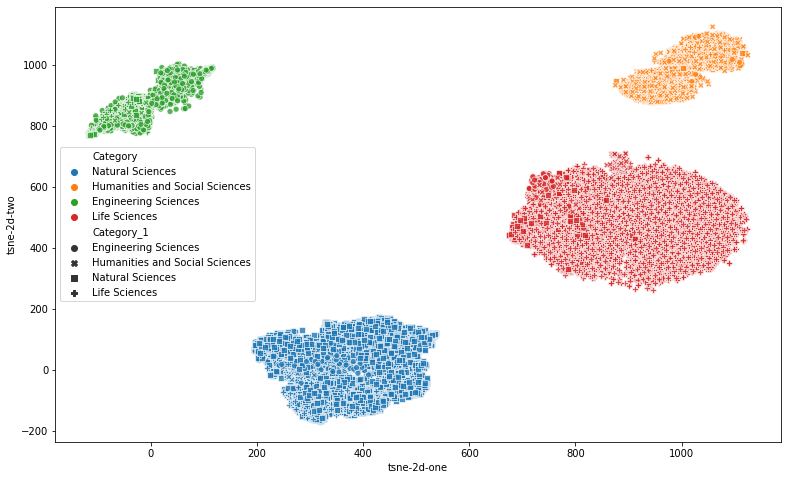

In [484]:
plt.figure(figsize=(13,8))
sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Category",
        data=Doc2VecModelData,
        legend="full",
        style='Category_1',
        alpha=0.8
    );

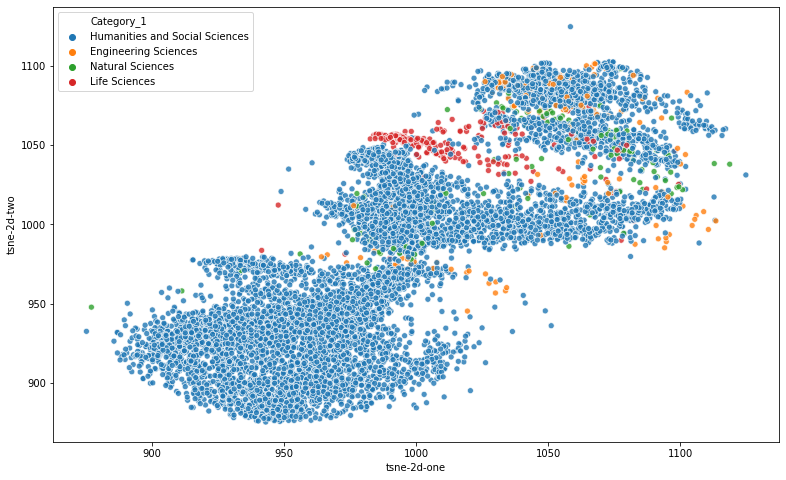

In [491]:
cat='Humanities and Social Sciences'#'Life Sciences'#'Engineering Sciences'
plt.figure(figsize=(13,8))
sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Category_1",
        data=Doc2VecModelData[Doc2VecModelData.Category==cat],
        legend="full",
#        style='Category_1',
        alpha=0.8
    );

In [468]:
## T-SNE all together

outerclusterfeatures=['Category_1_Values','Category_1_ID','Category_2_ID','Category_2_Values']

#Doc2VecModelData=NewMergedDSAligned2[outerclusterfeatures]
Doc2VecModelData=pd.concat([pd.DataFrame(model.docvecs.vectors_docs),NewMergedDSAligned2[outerclusterfeatures]], axis=1)

print(str(datetime.datetime.now()),'Started')
tsne = TSNE(n_components=2, perplexity=40, n_iter=300, learning_rate=100)
tsne_results = tsne.fit_transform(Doc2VecModelData)
#tsne_results=MinMaxScaler().fit_transform(tsne_results)

print(str(datetime.datetime.now()),'Completed')

Doc2VecModelData['Category'] = NewMergedDSAligned2.Category
Doc2VecModelData['tsne-2d-one'] = tsne_results[:,0]
Doc2VecModelData['tsne-2d-two'] = tsne_results[:,1]

# Reshaping
for cat in cats:
    model_x=MinMaxScaler([newrange[newrange['Category']==cat].Min_X.values[0],newrange[newrange['Category']==cat].Max_X.values[0]])
    Doc2VecModelData.loc[Doc2VecModelData['Category']==cat,'tsne-2d-one']=model_x.fit_transform(Doc2VecModelData[Doc2VecModelData['Category']==cat][['tsne-2d-one']])

    model_y=MinMaxScaler([newrange[newrange['Category']==cat].Min_Y.values[0],newrange[newrange['Category']==cat].Max_Y.values[0]])
    Doc2VecModelData.loc[Doc2VecModelData['Category']==cat,'tsne-2d-two']=model_y.fit_transform(Doc2VecModelData[Doc2VecModelData['Category']==cat][['tsne-2d-two']])


2020-01-18 17:34:24.233082 Started
2020-01-18 17:48:57.891819 Completed


In [486]:
Report_extrat=pd.concat([NewMergedDSAligned2[['Name','Institution','FundingFrom','FundingEnd', 'Category','Category_1_Values','Category_2_Values','Category_3_Values','Category_1','Category_2','Category_3']],Doc2VecModelData[['tsne-2d-one', 'tsne-2d-two']]], axis=1)

In [488]:
Report_extrat.to_csv(Path+'Report_WEPCADISOForestFindingsKMeans.csv', index=False)
newrange.to_csv(Path+'CATRANGE_WEPCAISOForestFindingsKMeans.csv', index=False)